# Financial and Accounting Analytics of Stock Returns during 2020 Covid-19 Pandemic 
BA870 - Financial Analytics - Final Project

Jordan Grose

## Project Introduction

The purpose of this project is to explain variation in stock returns during early and late fiscal 2020, which includes the beginning of the Covid-19 pandemic lockdown, for a group of about 2,800 publicly traded companies in the Russell 3000 Index. The variables we will use to explain returns variation include industry/sector categories (GIC Sectors and Industry Groups, SIC codes and NAICS codes), as well as various 2019 fiscal year financial ratios to control for the state of each company at the end of fiscal 2019 (beginning of 2020). The goal is to interpret how different industries performed and were affected by the covid-19 shock during 2020. Below are the financial variables used in this analysis:
- Price/Book = (PRCC_C * CSHO ) / CEQ
- P/E = (PRCC_C * CSHO ) / NI
- P/EBIT = (PRCC_C * CSHO ) / EBIT
- P/SALES = (PRCC_C * CSHO ) / SALE

The purpose for including financial ratios in our analysis is to control for various financial states and well-beings of companies across industries/sectors, as well as control for each individual company's state at the beginning of the fiscal 2020 year in explaining both early and late 2020 returns performance. Including industry/sector information as a fixed effect allows us to control for and understand the effects of the covid-19 shock across various industries. We will be using Ordinary Least Squares regressions to perform our analysis.

## Imports and OS setup

In [1]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mount Google drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
root_dir = "/content/gdrive/MyDrive/BA870 - Financial Analytics/Lecture 10/"
project_folder = "final_project/"

def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')
  os.chdir(root_dir + project_folder)

create_and_set_working_directory(project_folder)

## Data

The data we'll be using for this analysis comes from the WRDS Compustat database. Fiscal 2019 financial ratios for the roughly 2,800 companies were previously calculated using 2019 Compustat data on Stock Price, Common Shares Outstanding, Common Equity, Net Income (Loss), Sales, and EBIT. Returns are downloaded similarly from Compustat, but using monthly stock return data for 2020. Early returns are calculated by using returns data, including returns from the months January through March 2020, and late returns are calculated from April through December 2020. Also downloaded from WRDS are the industry & sector codes for each of the companies (GICS, SIC, NAICS). The datasets will be loaded into pandas dataframes through existing CSVs used to download the data. Below are the formulas used to calculate early and late 2020 returns:

RetEarly2020 = {(1+Ret[Jan 2020]) * (1+Ret[Feb 2020]) * (1+Ret[Mar 2020])} - 1

RetLate2020 = {(1+Ret[Apr 2020]) * (1+Ret[May 2020]) * (1+Ret[Jun 2020]) * (1+Ret[Jul 2020]) * (1+Ret[JAug 2020]) * (1+Ret[JSep 2020])*(1+Ret[Oct 2020]) * (1+Ret[Nov 2020]) * (1+Ret[Dec 2020])} - 1

## Loading the datasets

In [4]:
temp1 = pd.read_csv('temp1.csv') # fiscal 2020 early and late returns
temp2 = pd.read_csv('temp2.csv') # company financials for the fiscal year 2019
temp_industry = pd.read_csv('temp_industries.csv') # GICS (Industry Group & Sector), SIC, and NAICS codes

In [5]:
temp1.head(3)

,TICKER,RET_EARLY_2020,RET_LATE_2020
0,JJSF,-0.340234,0.300340
1,PLXS,-0.290876,0.433469
2,HNGR,-0.435712,0.411425


In [6]:
temp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TICKER          2711 non-null   object 
 1   RET_EARLY_2020  2711 non-null   float64
 2   RET_LATE_2020   2711 non-null   float64
dtypes: float64(2), object(1)
memory usage: 63.7+ KB


In [7]:
temp2.head(3)

,datadate,TICKER,CEQ,CSHO,EBIT,NI,SALE,PRCC_C
0,20200531,AIR,902.600,35.097,108.400,4.400,2089.300,45.10
1,20191231,AAL,-118.000,428.203,3706.000,1686.000,45768.000,28.68
2,20191231,CECE,193.017,35.137,19.622,17.707,341.869,7.66


In [8]:
temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682 entries, 0 to 2681
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datadate  2682 non-null   int64  
 1   TICKER    2682 non-null   object 
 2   CEQ       2679 non-null   float64
 3   CSHO      2679 non-null   float64
 4   EBIT      2679 non-null   float64
 5   NI        2679 non-null   float64
 6   SALE      2679 non-null   float64
 7   PRCC_C    2677 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 167.8+ KB


In [9]:
temp_industry.head(3)

,TICKER,GGROUP,GSECTOR,NAICS,SIC
0,AIR,2010,20,423860,5080
1,AAL,2030,20,481111,4512
2,CECE,2020,20,333413,3564


In [10]:
temp_industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TICKER   2838 non-null   object
 1   GGROUP   2838 non-null   int64 
 2   GSECTOR  2838 non-null   int64 
 3   NAICS    2838 non-null   int64 
 4   SIC      2838 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 111.0+ KB


## Merging and cleaning the datasets
Below we will merge the datasets and clean the data to account for missing values. We will also create our financial ratios mentioned above and winsorize the data to account for outliers. Additionally for SIC codes, we will only use the first two characters (numbers) of the code. Using the entire SIC code would provide us with too many industries to create fixed effect groups.

In [11]:
# dropping missing values from temp2, and dropping the date column from temp2
temp2 = temp2.drop(columns='datadate', axis=1)
temp2 = temp2.dropna(axis=0)
temp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2676 entries, 0 to 2681
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  2676 non-null   object 
 1   CEQ     2676 non-null   float64
 2   CSHO    2676 non-null   float64
 3   EBIT    2676 non-null   float64
 4   NI      2676 non-null   float64
 5   SALE    2676 non-null   float64
 6   PRCC_C  2676 non-null   float64
dtypes: float64(6), object(1)
memory usage: 167.2+ KB


In [12]:
# INNER JOIN merge the datasets temp1 and temp2
df = temp2.merge(temp1, how='inner', on='TICKER')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2687 entries, 0 to 2686
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TICKER          2687 non-null   object 
 1   CEQ             2687 non-null   float64
 2   CSHO            2687 non-null   float64
 3   EBIT            2687 non-null   float64
 4   NI              2687 non-null   float64
 5   SALE            2687 non-null   float64
 6   PRCC_C          2687 non-null   float64
 7   RET_EARLY_2020  2687 non-null   float64
 8   RET_LATE_2020   2687 non-null   float64
dtypes: float64(8), object(1)
memory usage: 209.9+ KB


In [13]:
# Creating our financial ratios
# We will be using the inverse of the ratios in our feature engineering to account for dividing by 0, which would result in NaN values in our dataset

df['PRICE__BOOK'] = df['CEQ'] / (df['PRCC_C'] * df['CSHO'])
df['P__E'] = df['NI'] / (df['PRCC_C'] * df['CSHO'])
df['P__EBIT'] = df['EBIT'] / (df['PRCC_C'] * df['CSHO'])
df['P__SALES'] = df['SALE'] / (df['PRCC_C'] * df['CSHO'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2687 entries, 0 to 2686
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TICKER          2687 non-null   object 
 1   CEQ             2687 non-null   float64
 2   CSHO            2687 non-null   float64
 3   EBIT            2687 non-null   float64
 4   NI              2687 non-null   float64
 5   SALE            2687 non-null   float64
 6   PRCC_C          2687 non-null   float64
 7   RET_EARLY_2020  2687 non-null   float64
 8   RET_LATE_2020   2687 non-null   float64
 9   PRICE__BOOK     2687 non-null   float64
 10  P__E            2687 non-null   float64
 11  P__EBIT         2687 non-null   float64
 12  P__SALES        2687 non-null   float64
dtypes: float64(12), object(1)
memory usage: 293.9+ KB


In [14]:
# dropping financial values from the dataframe since we only needed them to create the financial ratios
df = df.drop(columns=['CEQ', 'CSHO', 'EBIT', 'NI', 'SALE', 'PRCC_C'], axis=1)

### Winsorizing Financial Ratios

In [15]:
# checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2687 entries, 0 to 2686
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TICKER          2687 non-null   object 
 1   RET_EARLY_2020  2687 non-null   float64
 2   RET_LATE_2020   2687 non-null   float64
 3   PRICE__BOOK     2687 non-null   float64
 4   P__E            2687 non-null   float64
 5   P__EBIT         2687 non-null   float64
 6   P__SALES        2687 non-null   float64
dtypes: float64(6), object(1)
memory usage: 167.9+ KB


In [16]:
# observing the financial ratio statistics so we can identify outliers that might hurt our regression performance
df[['PRICE__BOOK', 'P__E', 'P__EBIT', 'P__SALES']].describe()

,PRICE__BOOK,P__E,P__EBIT,P__SALES
count,2687.000000,2687.000000,2687.000000,2687.000000
mean,0.482029,-0.002549,0.050287,0.886040
std,0.549539,0.352338,0.176190,1.968859
min,-6.491327,-11.813644,-3.217884,0.000000
25%,0.181664,-0.008351,0.018600,0.186029
50%,0.388718,0.034161,0.059929,0.386208
75%,0.701733,0.065474,0.112065,0.884378
max,8.673557,10.354951,2.645699,46.164318


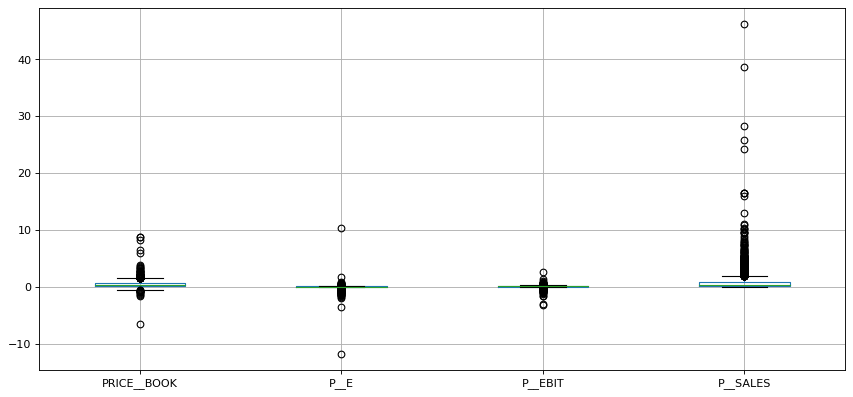

In [17]:
# boxplot to visualize any outliers
figure(figsize=(13, 6), dpi=80)
df[['PRICE__BOOK', 'P__E', 'P__EBIT', 'P__SALES']].boxplot()

All four ratios have some outliers that we'll want to winsorize at the 1% and 99% percentiles, especially P__SALES.

In [18]:
# winszoring the ratios to account for outliers at the 1% and 99% percentiles
df['PRICE__BOOK'] = winsorize(df['PRICE__BOOK'], limits=[0.01, 0.01])
df['P__E'] = winsorize(df['P__E'], limits=[0.01, 0.01])
df['P__EBIT'] = winsorize(df['P__EBIT'], limits=[0.01, 0.01])
df['P__SALES'] = winsorize(df['P__SALES'], limits=[0.01, 0.01])

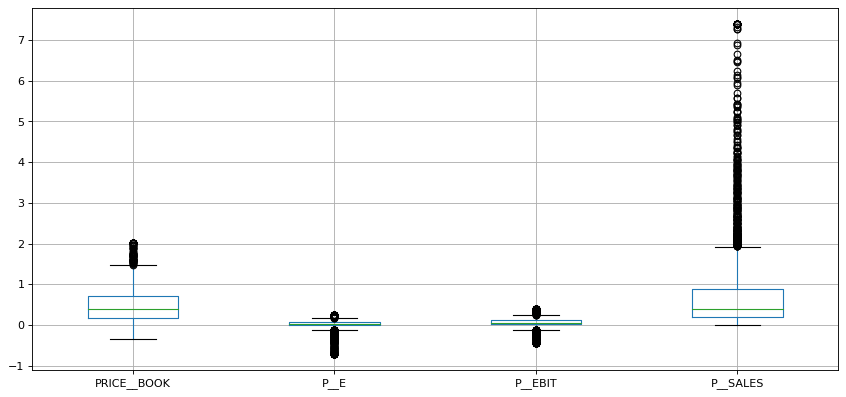

In [19]:
# Post-winsorizing boxplot
figure(figsize=(13, 6), dpi=80)
df[['PRICE__BOOK', 'P__E', 'P__EBIT', 'P__SALES']].boxplot()

### Cleaning and merging Industry and Sector data with our stocks data

In [20]:
# converting call industry codes to strings as their numeric value is meaningless
# this also allows us to clean the SIC strip the last digits of the SIC codes
temp_industry = temp_industry.astype('str')
temp_industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TICKER   2838 non-null   object
 1   GGROUP   2838 non-null   object
 2   GSECTOR  2838 non-null   object
 3   NAICS    2838 non-null   object
 4   SIC      2838 non-null   object
dtypes: object(5)
memory usage: 111.0+ KB


In [21]:
sic_stripped = []
for x in temp_industry['SIC']:
  x = x.strip()
  x = x[:-2]
  sic_stripped.append(x)
temp_industry['SIC'] = sic_stripped

In [22]:
temp_industry.head()

,TICKER,GGROUP,GSECTOR,NAICS,SIC
0,AIR,2010,20,423860,50
1,AAL,2030,20,481111,45
2,CECE,2020,20,333413,35
3,PNW,5510,55,2211,49
4,PRG,4020,40,522220,61


In [23]:
# merge data with temp_industry dataframe to include industry categories in the dataframe
df = df.merge(temp_industry, how='inner', on='TICKER')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2661 entries, 0 to 2660
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TICKER          2661 non-null   object 
 1   RET_EARLY_2020  2661 non-null   float64
 2   RET_LATE_2020   2661 non-null   float64
 3   PRICE__BOOK     2661 non-null   float64
 4   P__E            2661 non-null   float64
 5   P__EBIT         2661 non-null   float64
 6   P__SALES        2661 non-null   float64
 7   GGROUP          2661 non-null   object 
 8   GSECTOR         2661 non-null   object 
 9   NAICS           2661 non-null   object 
 10  SIC             2661 non-null   object 
dtypes: float64(6), object(5)
memory usage: 249.5+ KB


In [24]:
# Saving the dataframe to a CSV: financial_project.csv
df_tmp = df.copy()
df_tmp.to_csv(path_or_buf=root_dir + project_folder + '/final_proj_data.csv', index = False, header=True)

In [25]:
# Checking how many unique industry codes there are for each type of industry code
print(len(df.GGROUP.unique()))
print(len(df.GSECTOR.unique()))
print(len(df.NAICS.unique()))
print(len(df.SIC.unique()))

24
11
516
67


In [26]:
# creating a copy of the industry columns so we have a backup to group by industry before creating dummies.
df['GGROUP_CODE'] = df['GGROUP']
df['GSECTOR_CODE'] = df['GSECTOR']
df['SIC_CODE'] = df['SIC']

In [27]:
# Create Industry Categorical Dummies in separate dataframes
df_ggroup_dum = pd.get_dummies(df, columns=['GGROUP'])
df_gsector_dum = pd.get_dummies(df, columns=['GSECTOR'])
df_sic_dum = pd.get_dummies(df, columns=['SIC'])
df_naics_dum = pd.get_dummies(df, columns=['NAICS'])

## Financial Ratio's correlation
Next we'll look at correlations between our four financial ratios and early/late returns to see if we can identify any trends in 2020 returns performance based on the financial states of companies at the beginning of 2020.

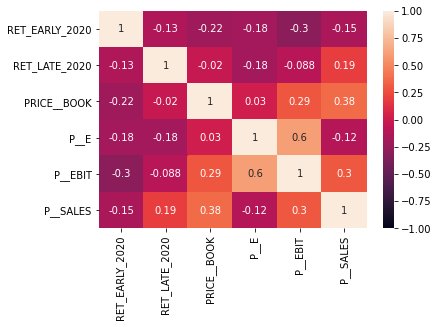

In [28]:
corr_mat = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.figsize = (15,12)

The highest correlation is between  P/E and P/EBIT. EBIT is closely related to Earnings so a high correlation is expected. We also observe small, negative correlations between both returns variables and all financial ratios. It's important to note the negative correlation as we think about regressions downstream -- we may expect to see negative coefficients on our financial ratios, although the significance of these relationships is still to be determined through regression analysis.


## Average returns by industry code
Before we begin our regression analysis, let's look at average returns for both early and late 2020 returns by segmenting by both a sector category and an industry category. We will use GSECTOR codes for our sector groups (of which there are 11 sectors) and SIC codes for our industry groups (of which there are 67). It's worth noting that our downstream regression analysis will also be done using GSECTOR and SIC codes. Due to a high number of NAICS codes (516), analyzing fixed effects on 516 different industries would realistically be difficult to interpret any signal.

In [29]:
# Average returns for GSECTORs
gsector_ret_early_df = df.groupby('GSECTOR')[['RET_EARLY_2020']].mean()
gsector_ret_late_df = df.groupby('GSECTOR')[['RET_LATE_2020']].mean()
gsector_ret_early_df.sort_values('RET_EARLY_2020', inplace=True)
gsector_ret_late_df.sort_values('RET_LATE_2020', inplace=True)

# Average returns for SICs
sic_ret_early_df = df.groupby('SIC')[['RET_EARLY_2020']].mean()
sic_ret_late_df = df.groupby('SIC')[['RET_LATE_2020']].mean()
sic_ret_early_df.sort_values('RET_EARLY_2020', inplace=True)
sic_ret_late_df.sort_values('RET_LATE_2020', inplace=True)

**GSECTOR: Min and Max for Average Early and Late 2020 Returns**

In [30]:
print(f'Minimum average early 2020 return is in GSECTOR: {gsector_ret_early_df[gsector_ret_early_df.RET_EARLY_2020==gsector_ret_early_df.RET_EARLY_2020.min()].index[0]}')
print(f'Maximum average early 2020 return is in GSECTOR: {gsector_ret_early_df[gsector_ret_early_df.RET_EARLY_2020==gsector_ret_early_df.RET_EARLY_2020.max()].index[0]}')
print(f'Minimum average late 2020 return is in GSECTOR: {gsector_ret_late_df[gsector_ret_late_df.RET_LATE_2020==gsector_ret_late_df.RET_LATE_2020.min()].index[0]}')
print(f'Maximum average late 2020 return is in GSECTOR: {gsector_ret_late_df[gsector_ret_late_df.RET_LATE_2020==gsector_ret_late_df.RET_LATE_2020.max()].index[0]}')

Minimum average early 2020 return is in GSECTOR: 10
Maximum average early 2020 return is in GSECTOR: 35
Minimum average late 2020 return is in GSECTOR: 55
Maximum average late 2020 return is in GSECTOR: 25


The sector with the minimum average early 2020 returns is GICS sector code 10, or the Energy Sector. Early 2020 returns (Jan - March) captures the beginning of the COVID shock period. At the beginning of 2020, Energy services and equipment providers experienced the lowest average stock returns. This could be due to the fact that during lockdown, many employees were in a stay at home format. The energy sector likely requires more physical labor for large energy and infrastructure projects, which would have been difficult during the beginning of quarantine, possibly hurting returns for this industry.

The sector with the maximum average early 2020 returns is GICS sector code 35, or the Healthcare Sector. This sector includes healthcare equipment and services providers as well as biotech and pharmaceutical companies. This makes sense as there was likely a rise in healthcare-related demand in the early parts of the pandemic (Jan - March 2020).

The sector with the minimum average late 2020 returns is GICS sector code 55, or the Utilities Sector (gas, water, electricity providers). Although consumers were in their homes and consuming utility services more in 2020 than other years, this could have hurt utility returns due to such a shock increase in demand for services, and thus an increase in expenses to supply utility services. Supplying utility services requires hands on work from employees. With many employees restricted during lockdown to come to work, the rise in utility demand combined with a lack of workforce and physical maintenance on utility service infrastructures, the cost to provide utilities may have been higher for these business, hurting their returns. Even if their revenue was higher during the year, costs likely increased more rapidly given the lockdown circumstances.

The sector with the maximum average late 2020 returns is GICS sector code 25, or the Consumer Discretionary sector. This sector includes business that provide consumer products and services (automobiles, apparel, home products, retail, as well as hotels). During late 2020, when we reached past the midpoint of the COVID-19 pandemic, it's likely that as society started to open back up, consumers were eager to by consumer products, boosting returns for businesses in this sector.

**SIC: Min and Max for Average Early and Late 2020 Returns**

In [31]:
print(f'Minimum average early 2020 return is in SIC: {sic_ret_early_df[sic_ret_early_df.RET_EARLY_2020==sic_ret_early_df.RET_EARLY_2020.min()].index[0]}')
print(f'Maximum average early 2020 return is in SIC: {sic_ret_early_df[sic_ret_early_df.RET_EARLY_2020==sic_ret_early_df.RET_EARLY_2020.max()].index[0]}')
print(f'Minimum average late 2020 return is in SIC: {sic_ret_late_df[sic_ret_late_df.RET_LATE_2020==sic_ret_late_df.RET_LATE_2020.min()].index[0]}')
print(f'Maximum average late 2020 return is in SIC: {sic_ret_late_df[sic_ret_late_df.RET_LATE_2020==sic_ret_late_df.RET_LATE_2020.max()].index[0]}')

Minimum average early 2020 return is in SIC: 13
Maximum average early 2020 return is in SIC: 2
Minimum average late 2020 return is in SIC: 2
Maximum average late 2020 return is in SIC: 52


The industry with the minimum average early 2020 returns is SIC code 13xx, or Energy industries specifically in oil and gas extraction. This is similar to our previous result with GICS Energy Sector having the minimum early 2020 average return and these SIC code 13xx companies are likely captured in the GICS Energy sector.

The industries with the maximum average late 2020 returns is SIC code 2xx. This code captures many industries from manufacturing to food & beverage producing and chemical manufacturing. Since SIC code 2xx contains many different industries, it's difficult to pinpoint exactly where the trends in max returns are.

Similarly to max early returns, minimum late returns in 2020 are also conatined in SIC code 2xx.

The industries with the maximum average late 2020 returns is SIC code 52xx, or home building materials and services (hardware stores, wallpaper, garden supplies). Perhaps after spending months inside their homes, consumers were eager to renovate or improve their homes. Once the pandemic mid-point was reached and society started opening back up, consumers may have taken this opportunity to improve their living situations for any future lockdowns.

## Fixed Effect Regressions on Early and Late 2020 Returns
Now we'll conduct regression analysis on early and late 2020 returns only using GICS Sector and SIC industry codes as fixed effects.

**Early Returns Regression: GICS Sectors as Fixed Effect**

In [32]:
x = df_gsector_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'PRICE__BOOK', 'P__E', 'P__EBIT', 'P__SALES', 'GGROUP', 'NAICS', 'SIC', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE'])
y = df_gsector_dum['RET_EARLY_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RET_EARLY_2020   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     36.03
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           1.18e-66
Time:                        00:52:32   Log-Likelihood:                -517.13
No. Observations:                2661   AIC:                             1056.
Df Residuals:                    2650   BIC:                             1121.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GSECTOR_10    -0.5807      0.029    -20.111      0.000      -0.637      -0.524
GSECTOR_15    -0.3509      0.027    -13.108      0.000      -0.403      -0.298
GSECTOR_20    -0.3218      0.015    -20.935      0.000      -0.352      -0.292
GSECTOR_25    -0.4130      0.017    -24.293      0.000      -0.446      -0.380
GSECTOR_30    -0.1912      0.029     -6.653      0.000      -0.248      -0.135
GSECTOR_35    -0.1386      0.013    -10.311      0.000      -0.165      -0.112
GSECTOR_40    -0.3464      0.013    -26.411      0.000      -0.372      -0.321
GSECTOR_45    -0.2170      0.016    -13.609      0.000      -0.248      -0.186
GSECTOR_50    -0.2884      0.030     -9.494      0.000      -0.348      -0.229
GSECTOR_55    -0.1479      0.035     -4.172      0.000      -0.217      -0.078
GSECTOR_60    -0.3281      0.022    -14.782      0.000      -0.372      -0.285
==============================================================================
Omnibus:                     4236.797   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4720750.568
Skew:                           9.816   Prob(JB):                         0.00
Kurtosis:                     208.406   Cond. No.                         2.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Late Returns Regression: GICS Sectors as Fixed Effect**

In [33]:
x = df_gsector_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'PRICE__BOOK', 'P__E', 'P__EBIT', 'P__SALES', 'GGROUP', 'NAICS', 'SIC', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE'])
y = df_gsector_dum['RET_LATE_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          RET_LATE_2020   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     27.13
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           7.99e-50
Time:                        00:52:32   Log-Likelihood:                -3829.0
No. Observations:                2661   AIC:                             7680.
Df Residuals:                    2650   BIC:                             7745.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GSECTOR_10     1.0175      0.100     10.150      0.000       0.821       1.214
GSECTOR_15     0.8732      0.093      9.396      0.000       0.691       1.055
GSECTOR_20     0.8052      0.053     15.090      0.000       0.701       0.910
GSECTOR_25     1.5339      0.059     25.988      0.000       1.418       1.650
GSECTOR_30     0.5252      0.100      5.265      0.000       0.330       0.721
GSECTOR_35     0.7397      0.047     15.853      0.000       0.648       0.831
GSECTOR_40     0.4980      0.046     10.935      0.000       0.409       0.587
GSECTOR_45     0.9988      0.055     18.042      0.000       0.890       1.107
GSECTOR_50     0.7616      0.105      7.223      0.000       0.555       0.968
GSECTOR_55     0.1812      0.123      1.472      0.141      -0.060       0.423
GSECTOR_60     0.4567      0.077      5.926      0.000       0.306       0.608
==============================================================================
Omnibus:                     2895.651   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           346833.045
Skew:                           5.283   Prob(JB):                         0.00
Kurtosis:                      57.923   Cond. No.                         2.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Early Returns Regression: SIC Industries as Fixed Effect**

In [34]:
x = df_sic_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'PRICE__BOOK', 'P__E', 'P__EBIT', 'P__SALES', 'GGROUP', 'NAICS', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE', 'GSECTOR'])
y = df_sic_dum['RET_EARLY_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RET_EARLY_2020   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.727
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           1.46e-41
Time:                        00:52:32   Log-Likelihood:                -505.76
No. Observations:                2661   AIC:                             1146.
Df Residuals:                    2594   BIC:                             1540.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SIC_1         -0.1957      0.133     -1.477      0.140      -0.456       0.064
SIC_10        -0.3647      0.099     -3.692      0.000      -0.558      -0.171
SIC_12        -0.5827      0.133     -4.397      0.000      -0.843      -0.323
SIC_13        -0.6772      0.041    -16.634      0.000      -0.757      -0.597
SIC_14        -0.4077      0.105     -3.891      0.000      -0.613      -0.202
SIC_15        -0.4149      0.070     -5.940      0.000      -0.552      -0.278
SIC_16        -0.3185      0.086     -3.722      0.000      -0.486      -0.151
SIC_17        -0.3020      0.121     -2.496      0.013      -0.539      -0.065
SIC_2          0.0288      0.296      0.097      0.923      -0.552       0.610
SIC_20        -0.1763      0.042     -4.248      0.000      -0.258      -0.095
SIC_21        -0.1991      0.171     -1.164      0.245      -0.535       0.136
SIC_22        -0.4745      0.148     -3.202      0.001      -0.765      -0.184
SIC_23        -0.4856      0.077     -6.346      0.000      -0.636      -0.336
SIC_24        -0.3789      0.086     -4.428      0.000      -0.547      -0.211
SIC_25        -0.4464      0.074     -6.024      0.000      -0.592      -0.301
SIC_26        -0.2591      0.070     -3.709      0.000      -0.396      -0.122
SIC_27        -0.3945      0.082     -4.799      0.000      -0.556      -0.233
SIC_28        -0.1568      0.016    -10.091      0.000      -0.187      -0.126
SIC_29        -0.4523      0.077     -5.910      0.000      -0.602      -0.302
SIC_30        -0.1687      0.070     -2.416      0.016      -0.306      -0.032
SIC_31        -0.4918      0.105     -4.694      0.000      -0.697      -0.286
SIC_32        -0.3404      0.105     -3.249      0.001      -0.546      -0.135
SIC_33        -0.4184      0.063     -6.622      0.000      -0.542      -0.295
SIC_34        -0.2722      0.050     -5.434      0.000      -0.370      -0.174
SIC_35        -0.3300      0.030    -10.965      0.000      -0.389      -0.271
SIC_36        -0.2729      0.026    -10.538      0.000      -0.324      -0.222
SIC_37        -0.4021      0.040    -10.152      0.000      -0.480      -0.324
SIC_38        -0.2022      0.026     -7.807      0.000      -0.253      -0.151
SIC_39        -0.3161      0.079     -3.991      0.000      -0.471      -0.161
SIC_40        -0.2079      0.148     -1.403      0.161      -0.498       0.083
SIC_41        -0.2185      0.210     -1.043      0.297      -0.629       0.192
SIC_42        -0.1906      0.074     -2.572      0.010      -0.336      -0.045
SIC_44        -0.4014      0.065     -6.206      0.000      -0.528      -0.275
SIC_45        -0.4800      0.074     -6.478      0.000      -0.625      -0.335
SIC_47        -0.2565      0.099     -2.596      0.009      -0.450      -0.063
SIC_48        -0.2420      0.043     -5.656      0.000      -0.326      -0.158
SI

**Late Returns Regression: SIC Industries as Fixed Effect**

In [35]:
x = df_sic_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'PRICE__BOOK', 'P__E', 'P__EBIT', 'P__SALES', 'GGROUP', 'NAICS', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE', 'GSECTOR'])
y = df_sic_dum['RET_LATE_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          RET_LATE_2020   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     5.951
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           6.91e-44
Time:                        00:52:32   Log-Likelihood:                -3771.1
No. Observations:                2661   AIC:                             7676.
Df Residuals:                    2594   BIC:                             8071.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SIC_1          0.1769      0.452      0.391      0.696      -0.710       1.064
SIC_10         1.6097      0.337      4.776      0.000       0.949       2.271
SIC_12         0.4580      0.452      1.013      0.311      -0.429       1.345
SIC_13         1.2905      0.139      9.292      0.000       1.018       1.563
SIC_14         1.0115      0.357      2.830      0.005       0.311       1.712
SIC_15         1.1786      0.238      4.946      0.000       0.711       1.646
SIC_16         1.0052      0.292      3.444      0.001       0.433       1.578
SIC_17         1.1604      0.413      2.811      0.005       0.351       1.970
SIC_2         -0.1464      1.011     -0.145      0.885      -2.129       1.836
SIC_20         0.6252      0.142      4.416      0.000       0.348       0.903
SIC_21         0.4802      0.584      0.823      0.411      -0.664       1.625
SIC_22         0.5863      0.506      1.160      0.246      -0.405       1.578
SIC_23         1.1662      0.261      4.467      0.000       0.654       1.678
SIC_24         1.0564      0.292      3.619      0.000       0.484       1.629
SIC_25         1.5839      0.253      6.266      0.000       1.088       2.080
SIC_26         0.4729      0.238      1.984      0.047       0.006       0.940
SIC_27         0.5121      0.280      1.826      0.068      -0.038       1.062
SIC_28         0.7320      0.053     13.812      0.000       0.628       0.836
SIC_29         0.5087      0.261      1.949      0.051      -0.003       1.021
SIC_30         1.9957      0.238      8.374      0.000       1.528       2.463
SIC_31         1.0166      0.357      2.844      0.004       0.316       1.718
SIC_32         0.7096      0.357      1.985      0.047       0.009       1.411
SIC_33         0.8994      0.216      4.172      0.000       0.477       1.322
SIC_34         0.7537      0.171      4.410      0.000       0.419       1.089
SIC_35         0.8900      0.103      8.670      0.000       0.689       1.091
SIC_36         1.2162      0.088     13.768      0.000       1.043       1.389
SIC_37         1.2985      0.135      9.611      0.000       1.034       1.563
SIC_38         0.7594      0.088      8.597      0.000       0.586       0.933
SIC_39         1.4322      0.270      5.300      0.000       0.902       1.962
SIC_40         0.5913      0.506      1.170      0.242      -0.400       1.583
SIC_41         0.8282      0.715      1.158      0.247      -0.574       2.230
SIC_42         0.7337      0.253      2.903      0.004       0.238       1.229
SIC_44         0.2054      0.221      0.931      0.352      -0.227       0.638
SIC_45         0.7191      0.253      2.845      0.004       0.223       1.215
SIC_47         0.9592      0.337      2.846      0.004       0.298       1.620
SIC_48         0.5319      0.146      3.645      0.000       0.246       0.818
SI

## Fixed Effect Regressions on Early and Late 2020 Returns Including Financial Ratios
Now we'll conduct regression analysis on early and late 2020 returns using GICS Sector and SIC industry codes as fixed effects, while also including our four financial ratios as independent variables to control for each company's, industry's and sector's financial state at the beginning of 2020.

**Early Returns Regression: GICS Sectors as Fixed Effect & Financial Ratios as Covariates**

In [36]:
x = df_gsector_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'GGROUP', 'NAICS', 'SIC', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE'])
x = sm.add_constant(x)
y = df_gsector_dum['RET_EARLY_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RET_EARLY_2020   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     38.02
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           8.33e-95
Time:                        00:52:33   Log-Likelihood:                -442.89
No. Observations:                2661   AIC:                             915.8
Df Residuals:                    2646   BIC:                             1004.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2105      0.010    -21.145      0.000      -0.230      -0.191
PRICE__BOOK    -0.0819      0.018     -4.525      0.000      -0.117      -0.046
P__E           -0.0878      0.060     -1.474      0.141      -0.205       0.029
P__EBIT        -0.5679      0.074     -7.659      0.000      -0.713      -0.423
P__SALES        0.0020      0.006      0.317      0.752      -0.010       0.014
GSECTOR_10     -0.2667      0.028     -9.696      0.000      -0.321      -0.213
GSECTOR_15     -0.0519      0.025     -2.094      0.036      -0.100      -0.003
GSECTOR_20     -0.0292      0.015     -1.907      0.057      -0.059       0.001
GSECTOR_25     -0.1236      0.017     -7.203      0.000      -0.157      -0.090
GSECTOR_30      0.0885      0.027      3.328      0.001       0.036       0.141
GSECTOR_35      0.0502      0.015      3.265      0.001       0.020       0.080
GSECTOR_40      0.0083      0.016      0.525      0.600      -0.023       0.039
GSECTOR_45      0.0244      0.016      1.533      0.125      -0.007       0.056
GSECTOR_50     -0.0053      0.028     -0.192      0.847      -0.060       0.049
GSECTOR_55      0.1437      0.032      4.458      0.000       0.081       0.207
GSECTOR_60     -0.0488      0.021     -2.315      0.021      -0.090      -0.007
==============================================================================
Omnibus:                     4151.602   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4475640.701
Skew:                           9.407   Prob(JB):                         0.00
Kurtosis:                     203.031   Cond. No.                     7.49e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Late Returns Regression: GICS Sectors as Fixed Effect & Financial Ratios as Covariates**

In [37]:
x = df_gsector_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'GGROUP', 'NAICS', 'SIC', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE'])
x = sm.add_constant(x)
y = df_gsector_dum['RET_LATE_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          RET_LATE_2020   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     29.14
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           1.80e-72
Time:                        00:52:33   Log-Likelihood:                -3767.9
No. Observations:                2661   AIC:                             7566.
Df Residuals:                    2646   BIC:                             7654.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6912      0.035     19.903      0.000       0.623       0.759
PRICE__BOOK    -0.1377      0.063     -2.182      0.029      -0.261      -0.014
P__E           -1.2205      0.208     -5.869      0.000      -1.628      -0.813
P__EBIT        -0.4961      0.259     -1.918      0.055      -1.003       0.011
P__SALES        0.1238      0.022      5.599      0.000       0.080       0.167
GSECTOR_10      0.2755      0.096      2.871      0.004       0.087       0.464
GSECTOR_15      0.1616      0.086      1.869      0.062      -0.008       0.331
GSECTOR_20      0.1042      0.053      1.950      0.051      -0.001       0.209
GSECTOR_25      0.7573      0.060     12.652      0.000       0.640       0.875
GSECTOR_30     -0.2445      0.093     -2.637      0.008      -0.426      -0.063
GSECTOR_35     -0.1061      0.054     -1.980      0.048      -0.211      -0.001
GSECTOR_40      0.0027      0.055      0.049      0.961      -0.106       0.111
GSECTOR_45      0.2785      0.056      5.018      0.000       0.170       0.387
GSECTOR_50      0.0495      0.097      0.512      0.609      -0.140       0.239
GSECTOR_55     -0.4397      0.112     -3.910      0.000      -0.660      -0.219
GSECTOR_60     -0.1478      0.074     -2.009      0.045      -0.292      -0.004
==============================================================================
Omnibus:                     2843.573   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           347717.943
Skew:                           5.102   Prob(JB):                         0.00
Kurtosis:                      58.064   Cond. No.                     7.49e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Early Returns Regression: SIC Industries as Fixed Effect & Financial Ratios as Covariates**

In [38]:
x = df_sic_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'GGROUP', 'NAICS', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE', 'GSECTOR'])
x = sm.add_constant(x)
y = df_sic_dum['RET_EARLY_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RET_EARLY_2020   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     8.330
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           2.40e-72
Time:                        00:52:33   Log-Likelihood:                -416.58
No. Observations:                2661   AIC:                             975.2
Df Residuals:                    2590   BIC:                             1393.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2331      0.016    -14.438      0.000      -0.265      -0.201
PRICE__BOOK    -0.0847      0.019     -4.508      0.000      -0.122      -0.048
P__E           -0.1443      0.061     -2.355      0.019      -0.264      -0.024
P__EBIT        -0.5706      0.076     -7.487      0.000      -0.720      -0.421
P__SALES       -0.0078      0.007     -1.095      0.274      -0.022       0.006
SIC_1           0.1470      0.127      1.154      0.249      -0.103       0.397
SIC_10         -0.1150      0.095     -1.205      0.228      -0.302       0.072
SIC_12         -0.1233      0.128     -0.966      0.334      -0.374       0.127
SIC_13         -0.3409      0.042     -8.080      0.000      -0.424      -0.258
SIC_14         -0.0811      0.101     -0.803      0.422      -0.279       0.117
SIC_15         -0.0256      0.068     -0.375      0.708      -0.159       0.108
SIC_16          0.0106      0.083      0.127      0.899      -0.152       0.173
SIC_17          0.0340      0.116      0.293      0.770      -0.194       0.262
SIC_2           0.3110      0.283      1.099      0.272      -0.244       0.866
SIC_20          0.1292      0.042      3.093      0.002       0.047       0.211
SIC_21          0.0979      0.164      0.597      0.550      -0.223       0.419
SIC_22         -0.1252      0.142     -0.882      0.378      -0.403       0.153
SIC_23         -0.1625      0.074     -2.191      0.029      -0.308      -0.017
SIC_24         -0.0690      0.083     -0.835      0.404      -0.231       0.093
SIC_25         -0.1197      0.072     -1.663      0.097      -0.261       0.021
SIC_26          0.1036      0.068      1.525      0.127      -0.030       0.237
SIC_27         -0.0463      0.080     -0.581      0.561      -0.203       0.110
SIC_28          0.0420      0.022      1.891      0.059      -0.002       0.086
SIC_29         -0.0720      0.074     -0.968      0.333      -0.218       0.074
SIC_30          0.1515      0.068      2.230      0.026       0.018       0.285
SIC_31         -0.1536      0.101     -1.524      0.128      -0.351       0.044
SIC_32          0.0053      0.101      0.053      0.958      -0.192       0.203
SIC_33         -0.0705      0.062     -1.142      0.254      -0.192       0.051
SIC_34          0.0641      0.050      1.293      0.196      -0.033       0.161
SIC_35         -0.0246      0.032     -0.777      0.437      -0.087       0.037
SIC_36          0.0111      0.028      0.393      0.694      -0.044       0.066
SIC_37         -0.0580      0.040     -1.446      0.148      -0.137       0.021
SIC_38          0.0529      0.029      1.845      0.065      -0.003       0.109
SIC_39         -0.0217      0.077     -0.283      0.777      -0.172       0.129
SIC_40          0.0979      0.142      0.689      0.491      -0.181       0.376
SIC_41         -0.0959      0.201     -0.47

**Late Returns Regression: SIC Industries as Fixed Effect & Financial Ratios as Covariates**

In [39]:
x = df_sic_dum.drop(columns=['TICKER', 'RET_EARLY_2020', 'RET_LATE_2020', 'GGROUP', 'NAICS', 'GGROUP_CODE', 'GSECTOR_CODE', 'SIC_CODE', 'GSECTOR'])
x = sm.add_constant(x)
y = df_sic_dum['RET_LATE_2020']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          RET_LATE_2020   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     7.468
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           7.21e-63
Time:                        00:52:33   Log-Likelihood:                -3714.1
No. Observations:                2661   AIC:                             7570.
Df Residuals:                    2590   BIC:                             7988.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7889      0.056     14.149      0.000       0.680       0.898
PRICE__BOOK    -0.0555      0.065     -0.856      0.392      -0.183       0.072
P__E           -0.9129      0.212     -4.315      0.000      -1.328      -0.498
P__EBIT        -0.6544      0.263     -2.487      0.013      -1.170      -0.138
P__SALES        0.1469      0.025      5.941      0.000       0.098       0.195
SIC_1          -0.6382      0.440     -1.451      0.147      -1.501       0.224
SIC_10          0.7445      0.330      2.259      0.024       0.098       1.391
SIC_12         -0.4333      0.441     -0.983      0.326      -1.297       0.431
SIC_13          0.3786      0.146      2.600      0.009       0.093       0.664
SIC_14          0.1221      0.349      0.350      0.726      -0.562       0.806
SIC_15          0.2740      0.235      1.164      0.245      -0.188       0.736
SIC_16         -0.0548      0.286     -0.191      0.848      -0.617       0.507
SIC_17          0.2855      0.401      0.712      0.477      -0.501       1.072
SIC_2          -0.9936      0.977     -1.017      0.309      -2.909       0.922
SIC_20         -0.2233      0.144     -1.548      0.122      -0.506       0.059
SIC_21         -0.2759      0.566     -0.488      0.626      -1.386       0.834
SIC_22         -0.2227      0.490     -0.454      0.650      -1.184       0.738
SIC_23          0.3498      0.256      1.366      0.172      -0.152       0.852
SIC_24          0.2194      0.285      0.769      0.442      -0.340       0.779
SIC_25          0.6424      0.249      2.585      0.010       0.155       1.130
SIC_26         -0.3863      0.235     -1.647      0.100      -0.846       0.074
SIC_27         -0.4891      0.275     -1.778      0.076      -1.029       0.050
SIC_28         -0.2292      0.077     -2.990      0.003      -0.380      -0.079
SIC_29         -0.4356      0.257     -1.695      0.090      -0.940       0.068
SIC_30          1.1315      0.235      4.823      0.000       0.671       1.591
SIC_31          0.1990      0.348      0.572      0.568      -0.483       0.881
SIC_32         -0.1914      0.348     -0.550      0.583      -0.874       0.491
SIC_33         -0.0611      0.213     -0.286      0.775      -0.479       0.357
SIC_34         -0.0990      0.171     -0.579      0.563      -0.435       0.237
SIC_35          0.0540      0.109      0.494      0.621      -0.160       0.268
SIC_36          0.3594      0.097      3.690      0.000       0.168       0.550
SIC_37          0.4037      0.139      2.912      0.004       0.132       0.675
SIC_38         -0.0835      0.099     -0.844      0.399      -0.278       0.111
SIC_39          0.4753      0.265      1.795      0.073      -0.044       0.995
SIC_40         -0.1188      0.490     -0.242      0.809      -1.081       0.843
SIC_41         -0.2779      0.694     -0.40

## Model Summaries and Interpretation of Results
Below are tables summarizing first the regressions on early and late 2020 returns using only industry and sector fixed effects. The next table summarizes regressions on early and late 2020 returns using industry and sector fixed effects as well as the financial ratios as covariates

For Table 1, the first column represents the regression of concern (i.e. GSECTOR_EARLY --> Early_Returns ~ GSECTOR Fixed Effects). The 'Adj-R2' column represents the adjusted R-squared value for the regression. The '% Significant FE' represents the percentage of industry/sector code fixed effect coefficients that exhibited statistical significance at at least the 5% level (95% confidence).

For Table 2, the first three columns follow the same format as Table 1, but the fourth column '% Significant Ratios', represents the percantage of financial ratio coefficients that exhibited statistical significance at at least the 5% level (95% confidence interval).

These tables will help us understand which regressions (i.e. which fixed effects and covariates) yield the model with the highest predictive performance.

**Table 1: Industry and Sector Fixed Effects Regressions**

|               | Adj-R2 | % Significant FE |
|---------------|--------|------------------|
| GSECTOR_EARLY | 0.116  | 100%             |
| GSECTOR_LATE  | 0.089  | 90.9%            |
| SIC_EARLY     | 0.105  | 83.5%            |
| SIC_LATE      | 0.109  | 71.6%            |

**Table 2: Industry and Sector Fixed Effects & Financial Ratio Covariates Regressions**

|               | Adj-R2 | % Significant FE | % Significant Ratios |
|---------------|--------|------------------|----------------------|
| GSECTOR_EARLY | 0.163  | 63.6%            | 50%                  |
| GSECTOR_LATE  | 0.129  | 63.6%            | 75%                  |
| SIC_EARLY     | 0.162  | 20.8%            | 75%                  |
| SIC_LATE      | 0.145  | 28.3%            | 75%                  |

Overall the model with the best Adj-R2 (percent variation in Early/Late Returns explained by variation in Industry/Sector and Financial Ratio values) is the regression of Early 2020 Returns on GICS Sectors as Fixed effects plus financial ratios as control variables, with an Adj-R2 of 0.163. Only ~16% of the variation in early returns is explained by these regressors, meaning there are other factors at play that may contribute to a companies returns during the Covid-19 Pandemic (i.e. market volatility, or lockdown circumstances) -- these things are difficult to identify, categorize, numeralize and put into a regression. However, we've learned that at a minimum, a company's particular sector can explain some variation in it's early returns during the 2020 pandemic year. This tells us that different industries were affected in various ways by the covid-19 pandemic, some better than others.

For both GSECTOR and SIC regressions, the models regressing early returns performed better than the models regressing late returns, meaning variation in early returns can be better explained by industry/sector than variation in late returns for the pandemic year. This makes sense as early returns capture the initial shock of the covid-19 lockdown period, when companies would have been most significantly and immediately affected. Late returns allow for 9 more months of recovery, giving various industries/sectors time to adjust and correct course -- allowing for increased variation in returns due to other factors not included in the models.

Both GSECTOR and SIC code fixed effects perform similarly in how they affect the Adj-R2 of the models (meaning one is not necessarily better than the other purely based on Adj-R2), however a higher percentage of the coefficients on GSECTOR fixed effects are statisticaly significant than that of SIC fixed effects. In other words, GSECTOR is a more reliable fixed effect than SIC in terms of significance on the model results.

For the models that include financial ratios as controls for the company's and industry's individual financial states at the beginning of the period, at least 50% of the ratio coefficients were significant, 75% were significant for 3/4 of the models. This tells us that controlling for financial states in the same industries helps to improve the model performance. This can be confirmed by looking at the Adj-R2 values in Table two (regressions that include ratios as controls). All of the Adj-R2 values for regressions that include financial ratios are higher than all the models that do not include financial ratios. In other words, keeping financial ratios in the regression improves the model performance from an explanatory power perspective.